In [ ]:
#           annotations_trainval2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!rm annotations_trainval2014.zip


  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [ ]:
#                 train2014.zip

!wget http://images.cocodataset.org/zips/train2014.zip
!unzip /content/train2014.zip
!rm train2014.zip

In [ ]:
#             image_info_test2014.zip

!wget http://images.cocodataset.org/annotations/image_info_test2014.zip
!unzip /content/image_info_test2014.zip
!rm image_info_test2014.zip

In [ ]:
# #                  val2014.zip

# !wget http://images.cocodataset.org/zips/val2014.zip
# !unzip /content/val2014.zip
# !rm val2014.zip

In [ ]:
#                 test2014.zip

!wget http://images.cocodataset.org/zips/test2014.zip
!unzip /content/test2014.zip
!rm test2014.zip

In [ ]:
#                 COCO dataset

!git clone https://github.com/cocodataset/cocoapi.git
!coco/PythonAPI
!make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/bin/bash: coco/PythonAPI: No such file or directory
make: *** No targets specified and no makefile found.  Stop.


In [ ]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pickle
import os.path
from collections import Counter
import os
import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
!pip install nltk
import nltk
nltk.download('punkt')
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import math
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
c = Counter()

In [ ]:
c.update("a")
c.update("b")

In [ ]:
c

Counter({'a': 1, 'b': 1})

In [ ]:
c.items()

dict_items([('a', 1), ('b', 1)])

https://github.com/sauravraghuvanshi/Udacity-Computer-Vision-Nanodegree-Program/tree/master/project_2_image_captioning_project

https://stackoverflow.com/questions/57030670/how-to-remove-punctuation-and-numbers-during-tweettokenizer-step-in-nlp

In [ ]:
class Vocabulary(object):

    def __init__(self, vocab_threshold, vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw4/vocab.pkl',
        start_word="<start>", end_word="<end>", unk_word="<unk>",
        annotations_file='/content/annotations/captions_train2014.json', vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            # Remove punctuation by using regex
            rp_caption = re.sub(r'[^\w\s]','',caption)
            #remove numbers
            rnp_caption = re.sub(r'\d+', '', rp_caption)
            tokens = nltk.tokenize.word_tokenize(rnp_caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Making vocabulary

In [ ]:
vocab_file = '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw4/vocab.pkl'
annotations_file = '/content/annotations/captions_train2014.json'
img_folder = '/content/images/test2014/'
num_workers = 0

train_dataset = CoCoDataset(transform=transform_train,
                          mode='train',
                          batch_size=64,
                          vocab_threshold=6,
                          vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/vocab.pkl',
                          start_word='<sos>',
                          end_word='<eos>',
                          unk_word='<ukn>',
                          annotations_file="/content/annotations/captions_train2014.json",
                          vocab_from_file=False,
                          img_folder='/content/train2014/')
print("Vocabulary is creaated!")

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:38<00:00, 10695.26it/s]


Vocabulary is creaated!


load vocabulary

In [ ]:
train_dataset = CoCoDataset(transform=transform_train,
                          mode='train',
                          batch_size=64,
                          vocab_threshold=6,
                          vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/vocab.pkl',
                          start_word='<sos>',
                          end_word='<eos>',
                          unk_word='<ukn>',
                          annotations_file="/content/annotations/captions_train2014.json",
                          vocab_from_file=True,
                          img_folder='/content/train2014/')
indices = train_dataset.get_train_indices()
initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader = data.DataLoader(dataset=train_dataset,
                              num_workers=0,
                              batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,batch_size=train_dataset.batch_size,drop_last=False))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:38<00:00, 10653.28it/s]


In [ ]:
# first_batch = next(iter(data_loader))

In [ ]:
# first_batch[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# first_batch[1][1]

tensor([   0,    3, 1808,  533,   20,   19,    6,  172,  759,    2,    1])

In [ ]:
class ECNN(nn.Module):

    def __init__(self, embed_size):
        super(ECNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features

In [ ]:
class DRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = 1, bias = True, batch_first = True, dropout = 0, bidirectional = False)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, init_hidden):
        captions = captions[:, :-1]
        self.hidden = init_hidden
        embeddings = self.word_embeddings(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_out, self.hidden = self.lstm(embeddings, self.hidden)
        outputs = self.linear(lstm_out)

        return outputs

In [ ]:
class ImageCaptioning(nn.Module):

    def __init__(self, ecnn, drnn, batch_size, hidden_size, device):
        super().__init__()
        self.encoder = ecnn
        self.decoder = drnn
        self.device = device
        self.batch_size = batch_size
        self.hidden_size = hidden_size

    def init_hidden(self):
        return (torch.zeros((1, self.batch_size, self.hidden_size), device=device), \
                torch.zeros((1, self.batch_size, self.hidden_size), device=device))

    def forward(self, images, captions):
        init_hdn = self.init_hidden()
        features = self.encoder(images)
        outputs = self.decoder(features, captions, init_hdn)
        return outputs
    def caption(self, image):
        image = image.to(device)
        features = self.encoder(image).unsqueeze(1)
        print("features.shape: ", features.shape)
        output = self.decoder.sample(features)
        print('example output:', output)
        return "OK"
        ## Greedy search
    def sample(self, inputs):
        output = []
        batch_size = inputs.shape[0]
        hidden = self.init_hidden()

        while True:
            lstm_out, hidden = self.decoder.lstm(inputs, hidden)
            outputs = self.decoder.linear(lstm_out)
            outputs = outputs.squeeze(1)
            _, max_indice = torch.max(outputs, dim=1)
            output.append(max_indice.cpu().numpy()[0].item())
            if (max_indice == 1):
                break
            inputs = self.decoder.word_embeddings(max_indice)
            inputs = inputs.unsqueeze(1)

        return output

In [ ]:
batch_size = 64
vocab_threshold = 6
vocab_from_file = True
embed_size = 512
hidden_size = 512
num_epochs = 1
save_every = 1
print_every = 200
vocab_size = len(data_loader.dataset.vocab)
enc = ECNN(embed_size)
dec = DRNN(embed_size, hidden_size, vocab_size)
ImageCModel = ImageCaptioning(enc, dec, batch_size, hidden_size, device).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
params =list(ImageCModel.decoder.parameters()) + list(ImageCModel.encoder.embed.parameters()) + list(ImageCModel.encoder.batch.parameters())
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

In [ ]:
import torch.utils.data as data
import numpy as np
import os

# total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
for epoch in range(1, num_epochs+1):

    for i_step in range(1, total_step+1):

        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        images, captions = next(iter(data_loader))
        images = images.to(device)
        captions = captions.to(device)
        ImageCModel.zero_grad()
        outputs = ImageCModel(images, captions)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        print('\r' + stats, end="")
        sys.stdout.flush()
        if i_step % print_every == 0:
            print('\r' + stats)

Epoch [1/1], Step [200/6471], Loss: 3.5885, Perplexity: 36.1800
Epoch [1/1], Step [400/6471], Loss: 3.0191, Perplexity: 20.4732
Epoch [1/1], Step [600/6471], Loss: 2.8106, Perplexity: 16.6202
Epoch [1/1], Step [800/6471], Loss: 2.6871, Perplexity: 14.6896
Epoch [1/1], Step [1000/6471], Loss: 2.6312, Perplexity: 13.8910
Epoch [1/1], Step [1200/6471], Loss: 2.3921, Perplexity: 10.9367
Epoch [1/1], Step [1400/6471], Loss: 3.1000, Perplexity: 22.1978
Epoch [1/1], Step [1600/6471], Loss: 2.9083, Perplexity: 18.3259
Epoch [1/1], Step [1800/6471], Loss: 2.1611, Perplexity: 8.6804
Epoch [1/1], Step [2000/6471], Loss: 2.5608, Perplexity: 12.9459
Epoch [1/1], Step [2200/6471], Loss: 2.1982, Perplexity: 9.0085
Epoch [1/1], Step [2400/6471], Loss: 2.1127, Perplexity: 8.2702
Epoch [1/1], Step [2600/6471], Loss: 2.1169, Perplexity: 8.3052
Epoch [1/1], Step [2800/6471], Loss: 2.2700, Perplexity: 9.6792
Epoch [1/1], Step [3000/6471], Loss: 2.1998, Perplexity: 9.0236
Epoch [1/1], Step [3200/6471], Loss

In [ ]:
torch.save(ImageCModel, "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/ImCap_Model.pkl")

In [ ]:
model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/ImCap_Model.pkl")

In [ ]:
torch.save(ImageCModel.encoder, "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/enc.pkl")
torch.save(ImageCModel.decoder, "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/dec.pkl")

In [ ]:
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<sos>': 0,
 '<eos>': 1,
 '<ukn>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

In [ ]:
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
vocab_from_file=True
tdataset = CoCoDataset(transform=transform_test,
                          mode='test',
                          batch_size=1,
                          vocab_threshold=6,
                          vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/vocab.pkl',
                          start_word='<sos>',
                          end_word='<eos>',
                          unk_word='<ukn>',
                          annotations_file='/content/annotations/image_info_test2014.json',
                          vocab_from_file=vocab_from_file,
                          img_folder='/content/test2014/')
test_loader = data.DataLoader(dataset=tdataset, batch_size=tdataset.batch_size, shuffle=True, num_workers=num_workers)

Vocabulary successfully loaded from vocab.pkl file!


In [ ]:
enc = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/enc.pkl")
enc.to(device)
enc.eval()
dec = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/HW4/dec.pkl")
dec.to(device)
dec.eval()
ImageCaptioningModel = ImageCaptioning(enc, dec, batch_size=1, hidden_size=512, device=device).to(device)

In [ ]:
def get_prediction():
    orig_image, image = next(iter(test_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = enc(image).unsqueeze(1)
    output = ImageCaptioningModel.sample(features)
    list_string = []
    for idx in output:
      list_string.append(data_loader.dataset.vocab.idx2word[idx])
    list_string = list_string[1:-1] # Discard <start> and <end> words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    print(sentence)

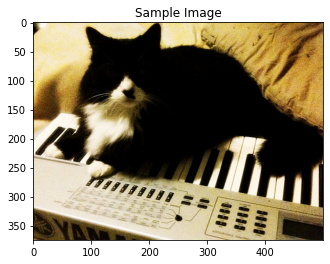

A cat sitting on top of a wooden table <ukn>


In [ ]:
get_prediction()

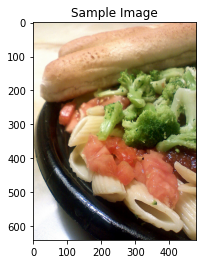

A plate of food with broccoli <ukn>


In [ ]:
get_prediction()

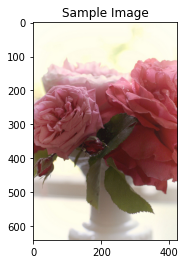

A white vase with a red and white flowers in it


In [ ]:
get_prediction()

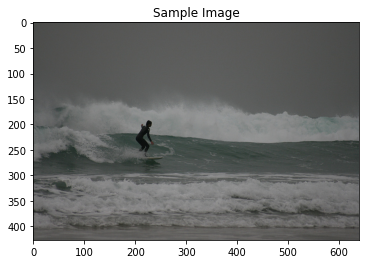

A man riding a wave on top of a surfboard <ukn>


In [ ]:
get_prediction()

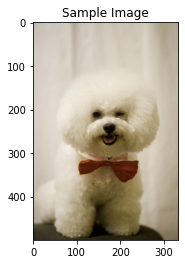

A white teddy bear sitting on top of a white bed <ukn>


In [ ]:
get_prediction()

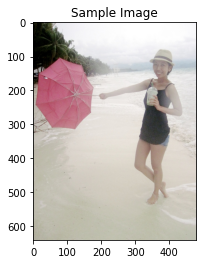

A woman standing on the beach holding a surfboard <ukn>


In [ ]:
get_prediction()

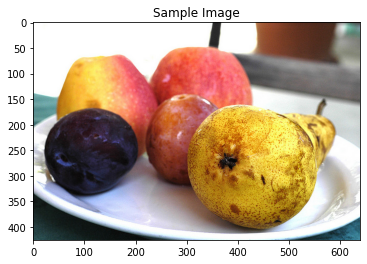

A plate of food that is on a table <ukn>


In [ ]:
get_prediction()

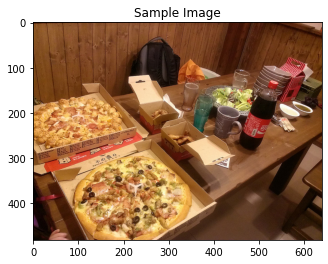

A table with a lot of different kinds of food


In [ ]:
get_prediction()

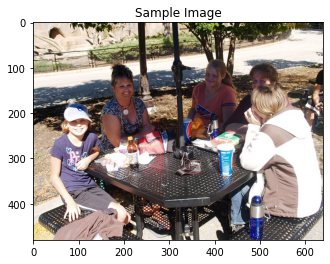

A group of people sitting at a table eating food <ukn>


In [ ]:
get_prediction()

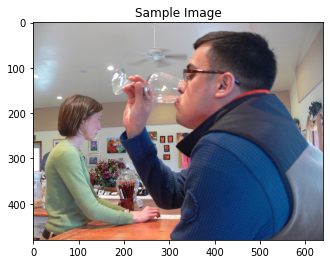

A man is holding a wii remote in his hand <ukn>


In [ ]:
get_prediction()

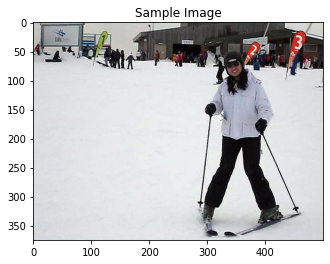

A man skiing down a snowy mountain with a snowboard <ukn>


In [ ]:
get_prediction()

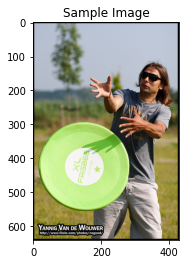

A woman is holding a frisbee in a field <ukn>


In [ ]:
get_prediction()

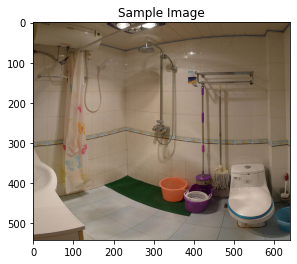

A bathroom with a toilet and a sink


In [ ]:
get_prediction()

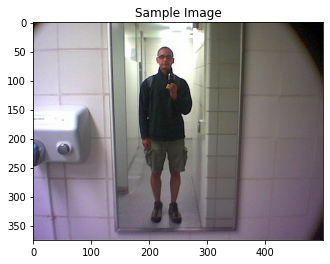

A man in a bathroom with a toilet and a shower


In [ ]:
get_prediction()